In [1]:
!pip install torchsde

In [12]:
import torch
from torch import nn
import torchsde
import numpy as np

import os
import sys
import tqdm

In [65]:
is_cuda = torch.cuda.is_available()
# is_cuda = False
device = 'cuda' if is_cuda else 'cpu'
if not is_cuda:
    print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")

Nuestro modelo, drift y difussion son redes neuronales que vamos a entrenar.

In [259]:
batch_size, state_size, brownian_size = 32, 1, 21

class SDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'

    def __init__(self):
        super().__init__()
        # TODO pasar a MLP
        self.net = []
        self.mu = torch.nn.Linear(2 * state_size, state_size)
        self.sigma = torch.nn.Linear(2 * state_size, state_size)

    # Drift
    def f(self, t, y):
        # armar un tensor de batch_size componentes con el tiempo t
        batch_t = torch.full((batch_size,1), t.item())
        # forward prop de la f
        # mu([
        #     (y_0, t), 
        #     (y_1, t),
        #     .. 
        #     (y_n, t) <--- n = batch_size
        # ]) 
        return self.mu(torch.cat((y, batch_t), dim=1))  # shape (batch_size, state_size)

    # Diffusion
    def g(self, t, y):
        # idem mu
        batch_t = torch.full((batch_size,1), t.item())
        return self.sigma(torch.cat((y, batch_t), dim=1))

sde = SDE().to(device)

Browniano Geométrico como benchmark conocido

In [5]:
class BGM_SDE(nn.Module):

    def __init__(self, mu, sigma):
        super().__init__()
        self.noise_type="diagonal"
        self.sde_type = "ito"

        self.mu = mu
        self.sigma = sigma

    def f(self, t, y):
        return self.mu * y

    def g(self, t, y):
        return self.sigma * y

## Earth Mover's Distance

In [6]:
def emd(p, q, steps=11):
  quantiles = torch.linspace(0, 1, steps=steps) 
  # tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000, 1.0000])
  p_q = torch.quantile(p, quantiles, dim=0, keepdim=True) # aproximacion numérica
  q_q = torch.quantile(q, quantiles, dim=0, keepdim=True)

  return torch.abs(p_q - q_q).sum().div(steps)

In [7]:
# Dos normales con misma varianza y un shift de una unidad, emd ~= 1 

p = torch.normal(mean=1, std=1, size=(300,), requires_grad=True)
q = torch.normal(mean=0, std=1, size=(300,), requires_grad=True)

res = emd(p, q, steps=11)
print(res)

del res, p, q

tensor(0.8980, grad_fn=<DivBackward0>)


### TorchSDE

In [274]:
# y0 dimension (batch_size, state_size) da el valor inicial de la SDE en tiempo ts[0]
y0 = torch.full((batch_size, state_size), 0.1)
ts = torch.linspace(0, 1, brownian_size)

bm = torchsde.BrownianInterval(t0=0, t1=1, size=(batch_size, state_size), device=device)

with torch.no_grad():
    # Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
    # ys will have shape (t_size, batch_size, state_size)
    ys = torchsde.sdeint(sde, y0, ts, method="euler", bm=bm)        
    ys_bgm = torchsde.sdeint(BGM_SDE(mu=a, sigma=b), y0, ts, method="euler", bm=bm)    

In [285]:
print(ys.shape) # (brownian_size, batch_size, state_size)

ys_bgm[-1,:,0]

torch.Size([21, 32, 1])


tensor([0.3057, 0.3156, 0.2566, 0.0205, 0.1875, 0.2218, 0.1416, 0.2495, 0.2945,
        0.3364, 0.3598, 0.2935, 0.2669, 0.2258, 0.2739, 0.1411, 0.4670, 0.2113,
        0.0227, 0.0428, 0.2401, 0.2686, 0.6885, 0.2979, 0.2335, 0.2506, 0.4630,
        0.6359, 0.3008, 0.0624, 0.2671, 0.1533])

In [288]:
emd(ys[-1,:,0], ys_bgm[-1,:,0])

tensor(0.5815)

<AxesSubplot:ylabel='Frequency'>

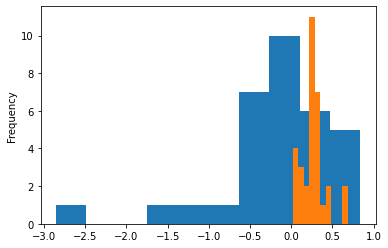

In [284]:
import pandas as pd
pd.Series(ys[-1,:,0].numpy()).plot.hist()
pd.Series(ys_bgm[-1,:,0].numpy()).plot.hist()

In [23]:
torchsde.sdeint?

In [328]:
steps = 2000
ts = torch.linspace(0, 1, brownian_size)

a, b = 1, 2
gbm = BGM_SDE(mu=a, sigma=b).to(device)
opt = torch.optim.Adam(sde.parameters(), lr=0.001)

# First run to preadjust values, should graph here
y0 = torch.full((batch_size, state_size), 0.1)

# bm_0 = torchsde.BrownianInterval(t0=0, t1=1, size=(batch_size, state_size), device=device)  
# st_0 = torchsde.sdeint(gbm, y0, ts=ts, method='euler', bm=bm)

# with torch.no_grad():
#     sde.mu.weight.copy_(st[-1,:,:][:,0].mean())
#     sde.sigma.weight.copy_(st[-1,:,:][:,0].std())
#     print(f"µ: {sde.mu.weight.item()}")
#     print(f"σ: {sde.sigma.weight.item()}")
    
losses = []
best_st = best_rt =  None 
best_loss = np.inf

trange = tqdm.tqdm(range(steps))
for step in trange:
    # TODO hacer afuera e iterar en for?
    opt.zero_grad()

    # Reciclamos y0 en todas las corridas
    bm_ = torchsde.BrownianInterval(t0=0, t1=1, size=(batch_size, state_size), device=device)  
    st = torchsde.sdeint(gbm, y0, ts, method='euler', bm=bm)
    bm = torchsde.BrownianInterval(t0=0, t1=1, size=(batch_size, state_size), device=device)  
    rt = torchsde.sdeint(sde, y0, ts, method='euler', bm=bm) # (brownian_size, batch_size, state_size)?

    # agarrar las ultimas para comparar
    wasserstein_loss = emd(st[-1,:,0], rt[-1,:,0])
    
    if best_loss > wasserstein_loss.item():
        best_st = st[-1,:,0].detach().numpy() 
        best_rt = rt[-1,:,0].detach().numpy()
        best_loss = wasserstein_loss.item()
    
    losses.append(wasserstein_loss.item())
    wasserstein_loss.backward()
    opt.step()


100%|███████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [1:01:07<00:00,  1.83s/it]


In [329]:
sde.mu.weight, sde.sigma.weight

(Parameter containing:
 tensor([[-0.1009,  0.2490]], requires_grad=True),
 Parameter containing:
 tensor([[1.1377, 0.1303]], requires_grad=True))

<AxesSubplot:>

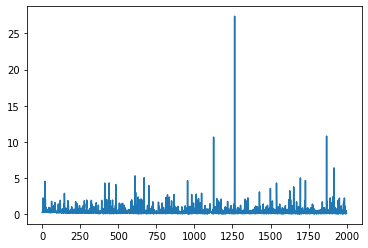

In [330]:
pd.Series(losses).plot()

<AxesSubplot:>

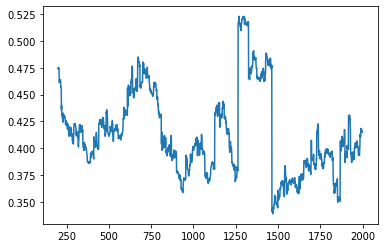

In [356]:
pd.Series(losses).rolling(200).mean().plot()

In [336]:
best_loss

0.025777267292141914

<AxesSubplot:ylabel='Frequency'>

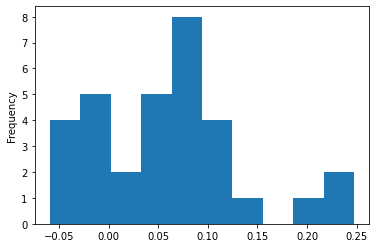

In [337]:
pd.Series(rt[-1:, :, 0][0].detach().numpy()).plot.hist()

<AxesSubplot:ylabel='Frequency'>

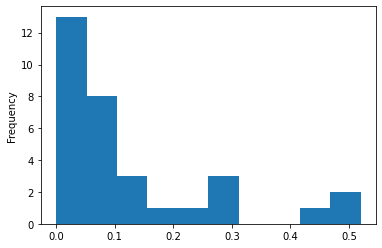

In [338]:
pd.Series(best_st).plot.hist()

<AxesSubplot:ylabel='Frequency'>

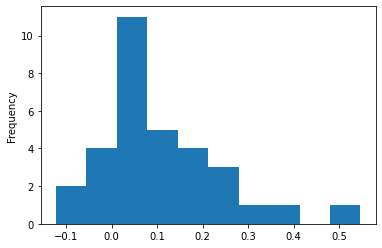

In [339]:
pd.Series(best_rt).plot.hist()

In [350]:
y0 = torch.full((batch_size, state_size), 0.1)

sts = rts = np.array([])
with torch.no_grad():
    for i in tqdm.tqdm(range(20)):
        bm_ = torchsde.BrownianInterval(t0=0, t1=1, size=(batch_size, state_size), device=device)  
        st = torchsde.sdeint(gbm, y0, ts, method='euler', bm=bm)
        bm = torchsde.BrownianInterval(t0=0, t1=1, size=(batch_size, state_size), device=device)  
        rt = torchsde.sdeint(sde, y0, ts, method='euler', bm=bm) # (brownian_size, batch_size, state_size)?
        sts = np.append(sts, st[-1:, :, :][0,:,0].detach().numpy())
        rts = np.append(rts, rt[-1:, :, :][0,:,0].detach().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.40s/it]


<AxesSubplot:ylabel='Frequency'>

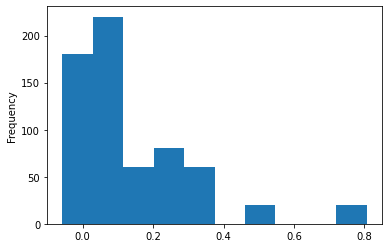

In [351]:
pd.Series(rts).plot.hist()

<AxesSubplot:ylabel='Frequency'>

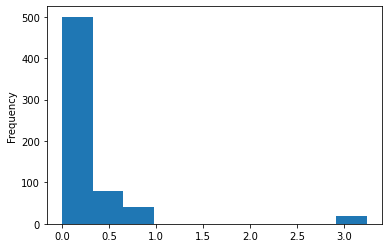

In [352]:
pd.Series(sts).plot.hist()

In [349]:
def price_func(s, k):
  # s y k vectores
  return max(s-k, 0)

In [357]:
best_loss

0.025777267292141914